# Exploration of Sales Data

Snohomish County Parcel Search:  
https://www.snoco.org/proptax/search.aspx?parcel_number= ***PARCELHERE***


In [250]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import combinations

### Data from Mongo Database

In [59]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

In [60]:
db = client['homesales_snohomish']
sales = db.homesales

In [61]:
rows = sales.find()
home_sales = pd.DataFrame(list(rows))
home_sales = home_sales.drop('_id', axis=1)

In [62]:
len(home_sales['Parcel #'].unique())

54029

### Data from csv

In [6]:
# home_sales1 = pd.read_csv(
#     'data/sales.csv',
#     index_col=0,
#     dtype={
#         'Parcel #': str,
#         'Year Built': str,
#         'Type': str,
#         'Quality/Grade': str,
#         'Address': str,
#         'City': str,
#         'Nbhd': str
#     }
# )

## Initial inspection

In [63]:
home_sales.head()

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code
0,31051100400500,1/31/2020 12:00:00 AM,"$2,500,000.00",5.44,,,,,21015 STATE ROUTE 9 NE,Arlington,Nbhd:5203000,521
1,00804500000100,1/31/2020 12:00:00 AM,"$416,000.00",0.29,1993,Tri Level,Avg,1430,20911 66TH AVE NE,Arlington,Nbhd:2408000,111
2,00960009607300,1/31/2020 12:00:00 AM,"$75,000.00",0,1996,Dbl Wide,V Good,1620,20227 80TH AVE NE SPC 73,Arlington,Nbhd:2408906,119
3,00874800005200,1/29/2020 12:00:00 AM,"$419,000.00",0.14,2001,1 1/2 Sty,Avg,1813,18127 GREYWALLS DR,Arlington,Nbhd:2408000,111
4,00946600000300,1/29/2020 12:00:00 AM,"$347,000.00",0.1166,2003,1 Sty,Avg-,1348,18722 35TH AVE NE,,Nbhd:2408000,111


In [64]:
home_sales.shape

(66691, 12)

## Data Cleaning

### Filters

#### Dates 

In [65]:
# ********** Clean Dates ***************
datetime.datetime.strptime(
    home_sales['Date of Sale'][0], '%m/%d/%Y %H:%M:%S %p')

datetime.datetime(2020, 1, 31, 12, 0)

In [66]:
def date_clean(d):
    return datetime.datetime.strptime(d, '%m/%d/%Y %H:%M:%S %p')

In [67]:
home_sales['Date of Sale'] = home_sales['Date of Sale'].map(date_clean)

#### Price

In [68]:
# ********** Clean Sale Price **********
def sale_price_clean(price):
    return float(price.strip('$').replace(',',''))

In [69]:
sale_price_clean(home_sales['Sale Price'][0])

2500000.0

In [70]:
home_sales['Sale Price'] = home_sales['Sale Price'].map(sale_price_clean)

#### Use Code, Sqft, Lot Size, 

In [71]:
home_sales['Use Code'] = home_sales['Use Code'].map(int)

In [74]:
def sqft_clean(sqft):
    if sqft:
        return float(sqft)
    else:
        return None

In [75]:
home_sales['Sqft'] = home_sales['Sqft'].map(sqft_clean)

In [76]:
home_sales['Lot Size'] = home_sales['Lot Size'].map(float)

In [77]:
def year_built_clean(year):
    if year:
        return int(year)
    else:
        return None

In [78]:
home_sales['Year Built'] = home_sales['Year Built'].map(year_built_clean)

#### Neighborhood

In [79]:
home_sales['Nbhd'][0].split(':')[1]

'5203000'

In [80]:
home_sales['Nbhd'] = home_sales['Nbhd'].map(lambda n: n.split(':')[1])

#### City

In [118]:
home_sales['City'].unique()

array(['Arlington', '', 'Bothell', 'Brier', 'Darrington', 'Edmonds',
       'Everett', 'Lynnwood', 'Goldbar', 'Granite Falls', 'Lake Stevens',
       'Marysville', 'Stanwood', 'Mill Creek', 'Monroe',
       'Mountlake Terrace', 'MUKILTEO', 'Snohomish', 'Sultan', 'Woodway',
       'BOT        Bothell', 'MIL        Mill Creek', 'LAKESTEVENS',
       'LYN        Lynnwood', 'BRI        Brier', 'Index', 'GF',
       'MILLCREEK', 'EDM        Edmonds', 'Woodinville', 'Mukilteo',
       'EVEEverett', 'STA        Stanwood', 'UNKNOWN'], dtype=object)

In [119]:
wrong_city = {
    'BOT        Bothell': 'Bothell',
    'MIL        Mill Creek': 'Mill Creek',
    'LAKESTEVENS': 'Lake Stevens',
    'LYN        Lynnwood': 'Lynnwood',
    'BRI        Brier': 'Brier',
    'GF': 'Granite Falls',
    'MILLCREEK': 'Mill Creek',
    'EDM        Edmonds': 'Edmonds',
    'MUKILTEO': 'Mukilteo',
    'EVEEverett': 'Everett',
    'STA        Stanwood': 'Stanwood',
    'UNKNOWN': ''
}
def clean_city(city):
    if city in wrong_city:
        return wrong_city[city]
    return city

In [120]:
home_sales['City'] = home_sales['City'].map(clean_city)

### Remove bad data

In [81]:
home_sales[home_sales['Year Built'] > 2021]

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code
2087,27052000205700,2020-03-04 12:00:00,462000.0,0.0502,2103.0,2+ Sty,Avg+,1773.0,2115 201ST PL SE UNIT R-102,,5608000,142
35457,01119900000600,2018-05-16 12:00:00,457000.0,0.0626,6619136.0,2 Sty,Avg+,1763.0,1129 120TH ST SE,,3311001,116
36221,00820700004200,2018-05-17 12:00:00,352000.0,0.2200,6619136.0,1 Sty,Avg-,1456.0,4105 122ND ST NE,Marysville,2413000,111
40715,01133200008300,2018-02-08 12:00:00,806000.0,0.0816,6619136.0,2 Sty,Avg+,2583.0,17018 40TH AVE SE,,3413000,111


In [82]:
# Removing rows where Year Built is greater than current year
home_sales.drop(home_sales[home_sales['Year Built'] > 2021].index, inplace=True)

Take a look at duplicates

#### Sales where parcel and date are same

In [91]:
# Create unique sales

home_sales['sale_id'] = home_sales['Parcel #'] + home_sales['Date of Sale'].map(str)

In [94]:
home_sales.iloc[0]['sale_id']

'310511004005002020-01-31 12:00:00'

In [93]:
# Sales with more than 1 entry
(home_sales.groupby('sale_id')['sale_id'].value_counts() > 1).count()

60421

In [95]:
unique_sales = home_sales.groupby('sale_id')['sale_id'].value_counts()

In [97]:
len(unique_sales[unique_sales > 1])

4851

In [98]:
home_sales = home_sales.drop_duplicates('sale_id', keep=False)

#### sales where price and date are same

In [125]:
home_sales['batch'] =  home_sales['Date of Sale'].map(str) + home_sales['Sale Price'].map(str)

In [126]:
batched_sales = home_sales.groupby('batch')['batch'].value_counts()

In [127]:
len(batched_sales[batched_sales > 1])

3255

In [128]:
home_sales = home_sales.drop_duplicates('batch', keep=False)

In [129]:
len(home_sales)

42433

#### Remove no sqft

In [155]:
home_sales = home_sales[home_sales['Sqft']>100]

In [225]:
home_sales[home_sales['Year Built']<1850]

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code,sale_id,batch
30639,01167700000800,2018-07-13 12:00:00,671782.0,0.0749,0.0,2 Sty,Avg+,1622.0,4510 187TH PL SE,,3511000,111,011677000008002018-07-13 12:00:00,2018-07-13 12:00:00671782.0


In [226]:
home_sales = home_sales[home_sales['Year Built']>1850]

## Looking at data

In [130]:
np.sort(home_sales['Use Code'].unique())

array([110, 111, 112, 116, 117, 118, 119, 121, 122, 123, 124, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145])

In [101]:
use_codes = np.load('data/use_codes.npy', allow_pickle='TRUE').item()

In [106]:
# drop rows where Use Code = 1
home_sales.drop(home_sales[home_sales['Use Code']==1].index, inplace=True)

We only want properties where people are living

In [109]:
home_sales = home_sales[home_sales['Use Code']<150]

In [131]:
home_sales.groupby('Use Code')['Use Code'].count()

Use Code
110        9
111    31103
112        6
116     1376
117      203
118     1064
119     1245
121       49
122      385
123       45
124       90
130       53
131       37
132        8
133        8
134        8
135        9
136       11
137       28
138        7
139       10
141     2438
142      651
143     2930
144        2
145      658
Name: Use Code, dtype: int64

In [132]:
home_sales.groupby('Type')['Type'].count()

Type
                 291
1 1/2 Sty        964
1 1/2 Sty B      520
1 Sty          12003
1 Sty B         2321
2 Sty          15900
2 Sty B         1489
2+ Sty          1877
2+ Sty B          32
Dbl Wide        1744
Dbl Wide B         5
Multi Level        6
Quad Level         6
Sgl Wide         711
Split Entry     3191
Tri Level       1316
Trpl Wide         57
Name: Type, dtype: int64

In [115]:
# home_sales[
#     (home_sales['Use Code']<150) & 
#     (home_sales['Type']=='2+ Sty') & 
#     (home_sales['Use Code']== 111)
# ]


In [164]:
# removed 112, 144
sfr_codes = [111,113,114,115,116,118,141,142,145]

#### Create dataframe for just single family residences

In [227]:
single_family = home_sales[home_sales['Use Code'].isin(sfr_codes)].copy()

In [166]:
single_family.head(3)

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code,sale_id,batch
1,00804500000100,2020-01-31 12:00:00,416000.0,0.2900,1993.0,Tri Level,Avg,1430.0,20911 66TH AVE NE,Arlington,2408000,111,008045000001002020-01-31 12:00:00,2020-01-31 12:00:00416000.0
3,00874800005200,2020-01-29 12:00:00,419000.0,0.1400,2001.0,1 1/2 Sty,Avg,1813.0,18127 GREYWALLS DR,Arlington,2408000,111,008748000052002020-01-29 12:00:00,2020-01-29 12:00:00419000.0
4,00946600000300,2020-01-29 12:00:00,347000.0,0.1166,2003.0,1 Sty,Avg-,1348.0,18722 35TH AVE NE,,2408000,111,009466000003002020-01-29 12:00:00,2020-01-29 12:00:00347000.0


In [167]:
home_sales['City'].unique()

array(['Arlington', '', 'Bothell', 'Brier', 'Darrington', 'Edmonds',
       'Everett', 'Lynnwood', 'Goldbar', 'Granite Falls', 'Lake Stevens',
       'Marysville', 'Stanwood', 'Mill Creek', 'Monroe',
       'Mountlake Terrace', 'Mukilteo', 'Snohomish', 'Sultan', 'Woodway',
       'Index', 'Woodinville'], dtype=object)

## Exploration

In [263]:
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
     '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
     '#bcbd22', '#17becf']
colors = c + c

In [264]:
single_family['price/sqft'] = single_family['Sale Price']/single_family['Sqft']

In [334]:
single_family= single_family[single_family['price/sqft']<2000]

#### Look for extremes

In [335]:
len(single_family[single_family['Sale Price'] < 10000])

272

In [336]:
len(single_family[single_family['Sale Price'] > 10000000])

0

In [337]:
single_family[single_family['Sqft'] < 200]

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code,sale_id,batch,price/sqft
25435,01049400210200,2018-10-11 12:00:00,27000.0,0.00,1997.0,1 Sty,Avg,115.0,12006 NE 204TH PL UNIT B102,,5620801,145,010494002102002018-10-11 12:00:00,2018-10-11 12:00:0027000.0,234.782609
26432,00556600009800,2018-10-26 12:00:00,295000.0,1.05,2005.0,Dbl Wide,Good,171.0,27103 176TH PL SE,,4120000,118,005566000098002018-10-26 12:00:00,2018-10-26 12:00:00295000.0,1725.146199


In [338]:
single_family.groupby('Use Code').mean()

,Sale Price,Lot Size,Year Built,Sqft,price/sqft
Use Code,,,,,
111,501269.519919,0.831495,1986.645579,2131.046660,244.780849
116,417827.066909,0.050439,2011.156364,1709.653818,245.580746
118,261822.941627,2.009448,1988.483254,1424.120096,191.742238
141,480911.088550,0.005939,2010.331960,1991.664745,243.593214
142,356452.440860,0.005656,2003.815668,1553.185868,230.261327
145,240042.794833,0.000000,1995.197568,909.144377,266.835497


In [339]:
fonts = {'fontsize':16, 'fontfamily':'serif'}

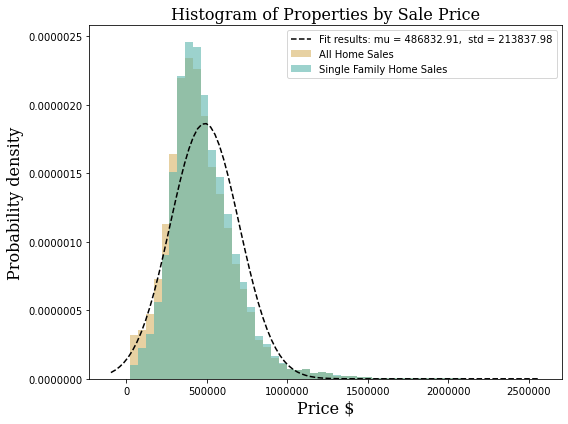

In [340]:
fig, ax = plt.subplots(figsize=(8,6))

# mu = single_family['Sale Price'].mean()
# std = single_family['Sale Price'].std()
home_sale_prices = home_sales[
    (home_sales['Sale Price'] < 2500000) &
    (home_sales['Sale Price'] > 25000)]['Sale Price']
single_family_prices = single_family[
    (single_family['Sale Price'] < 2500000) &
    (single_family['Sale Price'] > 25000)]['Sale Price']

ax.hist(home_sale_prices, 
        bins=50, 
        density=True, 
        alpha=.6, 
        color='#d8b365',
        label='All Home Sales')
n, bins, patches = ax.hist(single_family_prices, 
                           bins=50,
                           density=True, 
                           color='#5ab4ac', 
                           alpha=.6, 
                           label='Single Family Home Sales')


mu, std = stats.norm.fit(single_family_prices)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k--',label = "Fit results: mu = %.2f,  std = %.2f" % (mu, std))


# fit = stats.norm(loc=mu, scale=std).pdf(bins)
# ax.plot(bins,fit,'--')
# ax.set_xlim(0,2500000)
ax.set_xlabel('Price $', **fonts)
ax.set_ylabel('Probability density', **fonts)
ax.set_title('Histogram of Properties by Sale Price', **fonts)
ax.ticklabel_format(style='plain')
fig.tight_layout()
plt.legend()
plt.show()

In [341]:
mean_per_day = single_family.groupby('Date of Sale')['Sale Price'].mean()

In [343]:
# mean_per_day.index

In [345]:
# mean_per_day.rolling(3).mean()

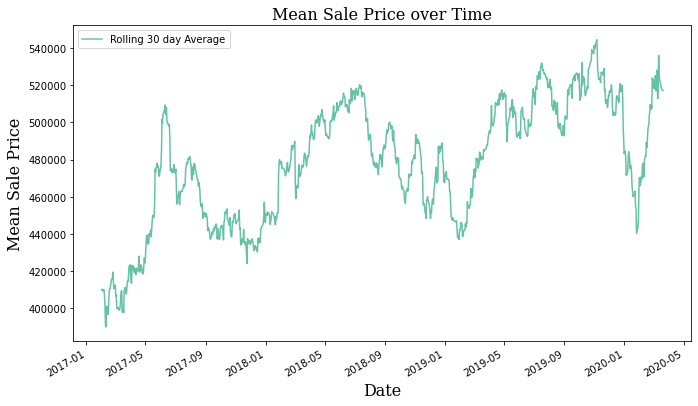

In [346]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(mean_per_day.rolling(30).mean(), color='#66c2a4', label='Rolling 30 day Average')
ax.set_xlabel('Date', **fonts)
ax.set_ylabel('Mean Sale Price', **fonts)
ax.set_title('Mean Sale Price over Time', **fonts)
fig.tight_layout()
fig.autofmt_xdate()
plt.legend()
plt.show()

In [347]:
single_family.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37233 entries, 1 to 66685
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Parcel #       37233 non-null  object        
 1   Date of Sale   37233 non-null  datetime64[ns]
 2   Sale Price     37233 non-null  float64       
 3   Lot Size       37233 non-null  float64       
 4   Year Built     37233 non-null  float64       
 5   Type           37233 non-null  object        
 6   Quality/Grade  37233 non-null  object        
 7   Sqft           37233 non-null  float64       
 8   Address        37233 non-null  object        
 9   City           37233 non-null  object        
 10  Nbhd           37233 non-null  object        
 11  Use Code       37233 non-null  int64         
 12  sale_id        37233 non-null  object        
 13  batch          37233 non-null  object        
 14  price/sqft     37233 non-null  float64       
dtypes: datetime64[ns](1

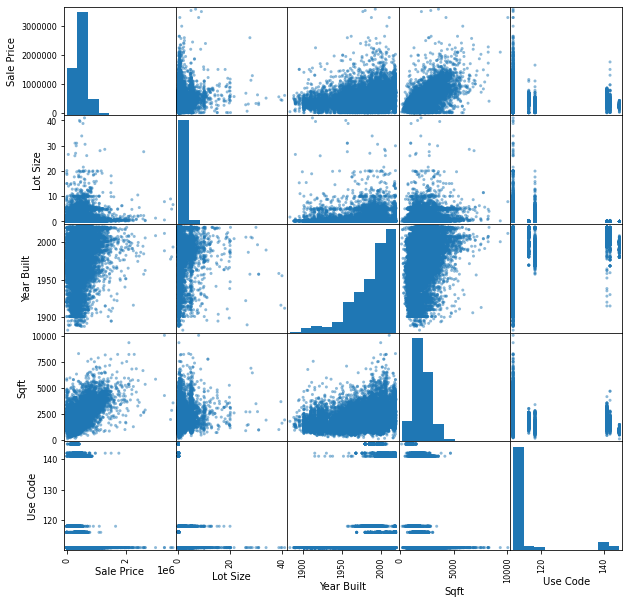

In [348]:
pd.plotting.scatter_matrix(
    single_family[
        single_family['Lot Size']<100
    ][[
        'Date of Sale', 
        'Sale Price',
        'Lot Size',
        'Year Built',
        'Type',
        'Quality/Grade',
        'Sqft',
        'Nbhd',
        'Use Code'
    ]], figsize=(10,10));

In [349]:
codes = np.sort(single_family['Use Code'].unique())

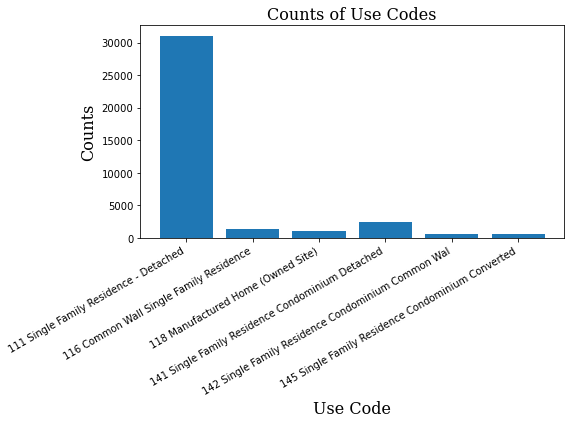

In [350]:
fig, ax = plt.subplots(figsize=(8,6))

ax.bar([use_codes[code] for code in codes], 
       single_family.groupby('Use Code')['Use Code'].value_counts())

ax.set_xlabel('Use Code', **fonts)
ax.set_ylabel('Counts', **fonts)
ax.set_title('Counts of Use Codes', **fonts)

fig.autofmt_xdate()
fig.tight_layout()
plt.show()

In [279]:
sf_2019_6000sq = single_family[
    (single_family['Date of Sale']>np.datetime64('2018-12-31'))& 
    (single_family['Date of Sale']<np.datetime64('2020-01-01'))&
    (single_family['Sqft']<6000)
]

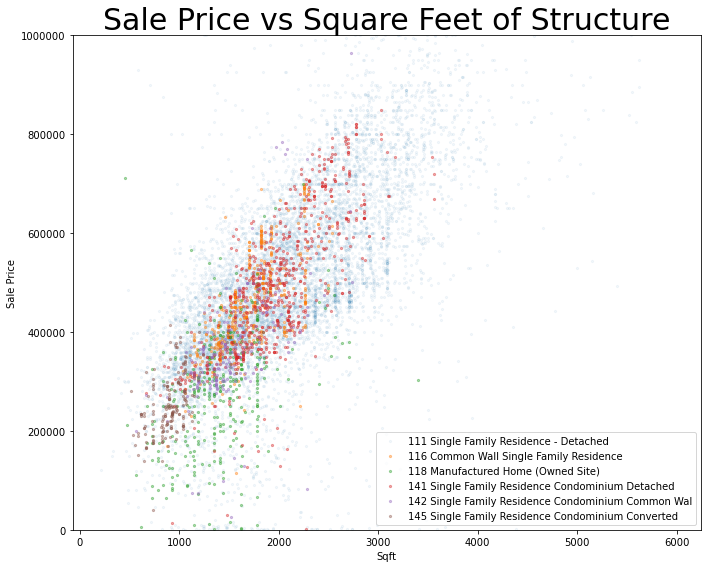

In [318]:

fig, ax = plt.subplots(figsize=(10,8))
for i, code in enumerate(codes):
    sf_2019_6000sq[sf_2019_6000sq["Use Code"] == code].plot.scatter(
        'Sqft', 'Sale Price', 
        color=colors[i],
        marker='.',
        alpha=(.05 if code==111 else 0.4), ax=ax,
        label="{}".format(use_codes[code]))
ax.set_ylim(0,1000000)
ax.set_title('Sale Price vs Square Feet of Structure', size=30)
ax.ticklabel_format(style='plain')
fig.tight_layout()

In [281]:
# single_family.info()

In [282]:
p_sqft_means = sf_2019_6000sq.groupby('Use Code')['price/sqft'].mean()
p_sqft_means

Use Code
111    260.382418
116    270.971499
118    211.103203
141    251.628378
142    244.777144
145    283.513333
Name: price/sqft, dtype: float64

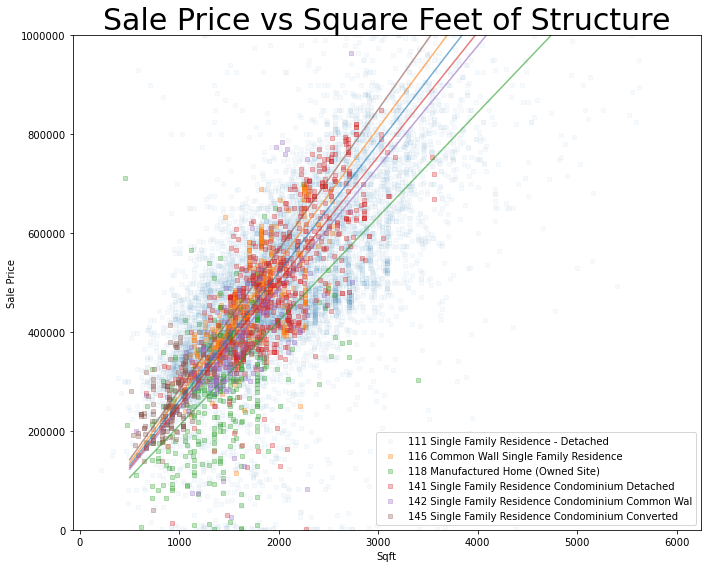

In [319]:
fig, ax = plt.subplots(figsize=(10,8))
for i, code in enumerate(codes):
    sf_2019_6000sq[sf_2019_6000sq["Use Code"] == code].plot.scatter(
        'Sqft', 'Sale Price', 
        color=colors[i],
        marker=',',
        alpha=(.03 if code==111 else 0.3), ax=ax,
        label="{}".format(use_codes[code]))
    ax.plot([500,5000], np.array([500,5000])*p_sqft_means[code],color=colors[i], alpha=.6)
    
ax.set_ylim(0,1000000)
ax.set_title('Sale Price vs Square Feet of Structure', size=30)
ax.ticklabel_format(style='plain')
fig.tight_layout()

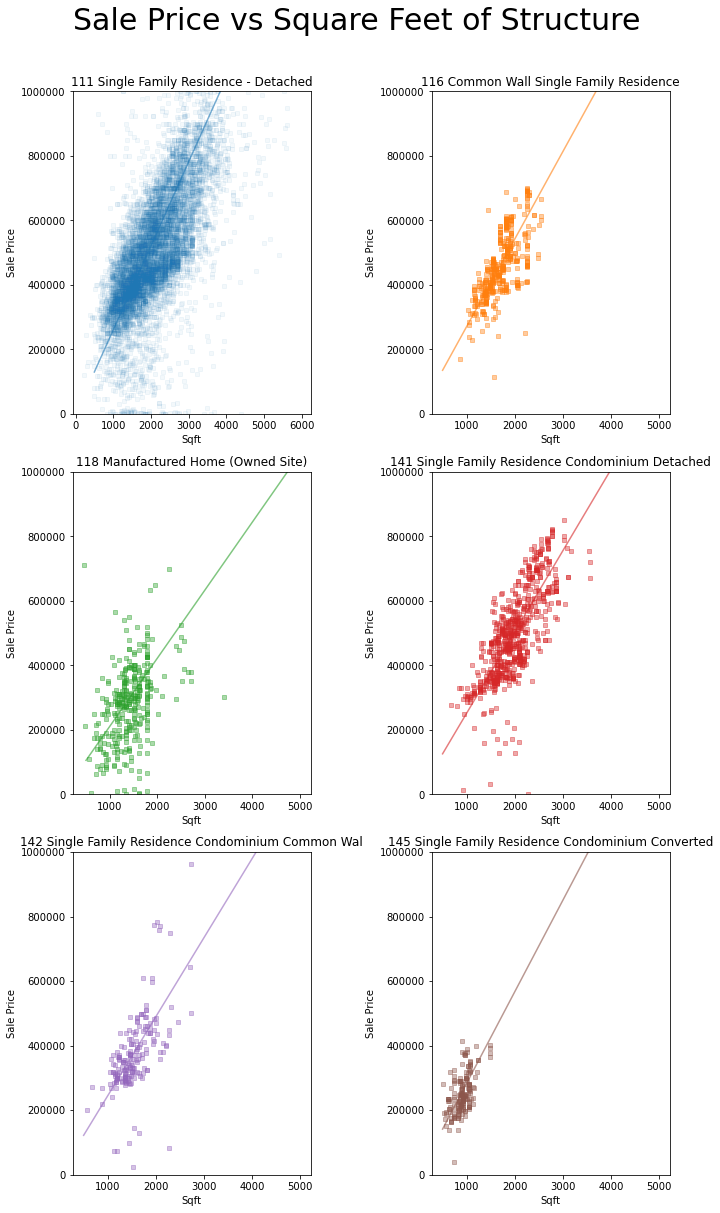

In [320]:
fig, ax1 = plt.subplots(3,2,figsize=(10,16))
axes = ax1.flatten()
for i, code in enumerate(codes):
    sf_2019_6000sq[sf_2019_6000sq["Use Code"] == code].plot.scatter(
        'Sqft', 
        'Sale Price',
        color=colors[i],
        marker=',',
        alpha=(.05 if code==111 else 0.4), 
        ax=axes[i])
    
    axes[i].plot([500,5000], np.array([500,5000])*p_sqft_means[code],
                 color=colors[i],
                 alpha=.6)
    axes[i].set_ylim(0,1000000)
    axes[i].set_title("{}".format(use_codes[code]))
    axes[i].ticklabel_format(style='plain')

fig.suptitle('Sale Price vs Square Feet of Structure',x=.5, y=1.05, size=30)
fig.tight_layout()
plt.show()

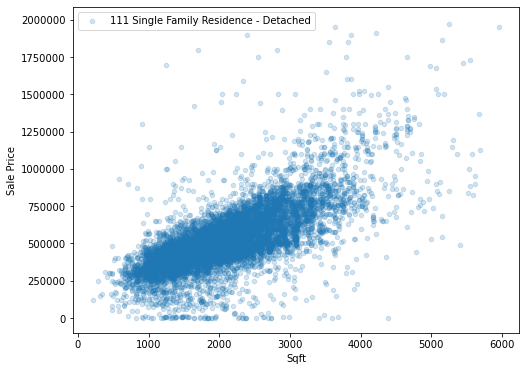

In [321]:
fig, ax = plt.subplots(figsize=(8,6))
sf_2019_6000sq[
    (sf_2019_6000sq["Use Code"] == 111) &
    (sf_2019_6000sq["Sale Price"] < 2000000)
].plot.scatter(
    'Sqft', 'Sale Price', 
    color=colors[0],
    alpha=0.2, 
    ax=ax,
    label="{}".format(use_codes[111]))
ax.ticklabel_format(style='plain');

In [182]:
single_family['Quality/Grade'].unique()

array(['Avg', 'Avg-', 'Fair', 'Good', 'Avg+', 'V Good', 'Low', 'Sub Std',
       ''], dtype=object)

### t-test for Use Codes

Lets find out if the price/sqft distributions are normal

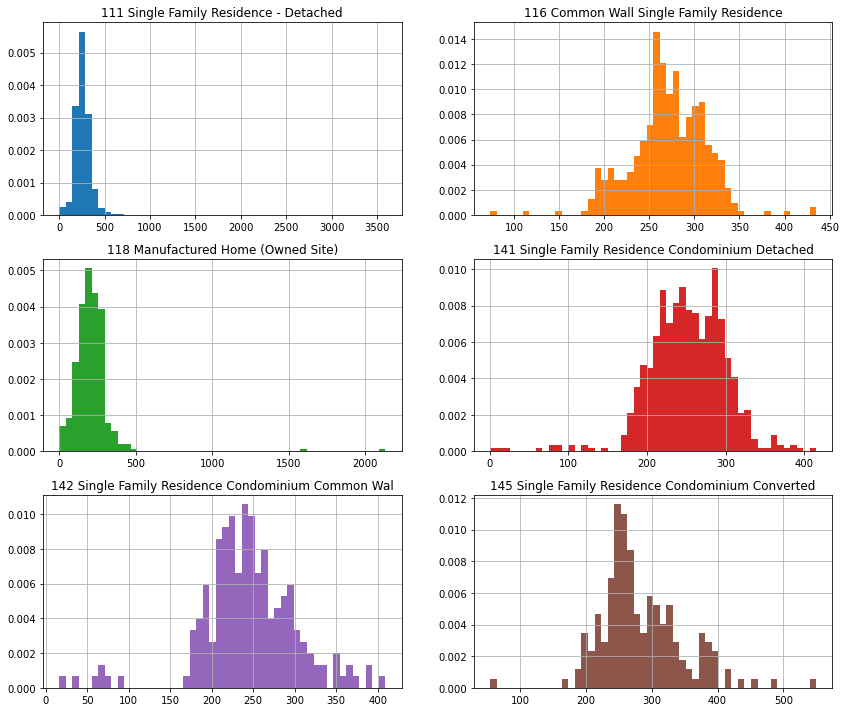

In [330]:
fig, ax1 = plt.subplots(3,2, figsize=(12,10))
axes = ax1.flatten()
for i, code in enumerate(codes):
    sf_2019_6000sq[sf_2019_6000sq["Use Code"] == code].hist(
        'price/sqft',
        bins=50,
        density=True,
        color=colors[i],
        ax=axes[i])

    axes[i].set_title("{}".format(use_codes[code]))

# fig.suptitle('Sale Price vs Square Feet of Structure',x=.5, y=1.05, size=30)
fig.tight_layout()
plt.show()

We want to see if Use Code has statistical significance when comparing price per square foot.  
Because there is little risk we will set $\alpha$ at 0.1

In [202]:
single_family.groupby('Use Code')['Use Code'].value_counts()

Use Code  Use Code
111       111         1216
112       112           18
116       116           40
118       118           61
141       141           82
142       142           28
Name: Use Code, dtype: int64

In [209]:
codes

array([111, 118, 141, 142, 112, 116])

In [214]:
code_ttests = []

In [215]:
for code1, code2 in combinations(codes, 2):
    s, p = stats.ttest_ind(
        single_family[(single_family['Use Code']==code1) & 
                      (single_family['price/sqft']>1)]['price/sqft'],
        single_family[(single_family['Use Code']==code2) &
                      (single_family['price/sqft']>1)]['price/sqft'])
    code_ttests.append((code1, code2, s, p))

In [ ]:
for code1, code2, s, p in code_ttests:
    

### By type

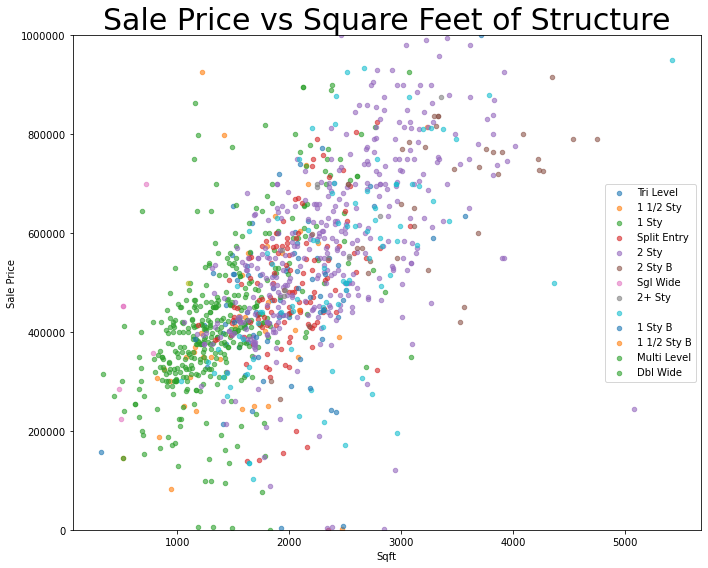

In [198]:
types = single_family[single_family["Use Code"] == 111]['Type'].unique()
fig, ax = plt.subplots(figsize=(10,8))
for i, typ in enumerate(types):
    single_family[(single_family["Use Code"] == 111) &
                  (single_family['Type']==typ) ].plot.scatter('Sqft', 'Sale Price', 
                                                    color=colors[i],
                                                    alpha=(.1 if code==111 else 0.6), ax=ax,
                                                   label="{}".format(typ))
ax.set_ylim(0,1000000)
ax.set_title('Sale Price vs Square Feet of Structure', size=30)
ax.ticklabel_format(style='plain')
fig.tight_layout()